In [1]:
using Plots, LinearAlgebra, Statistics, DataFrames, CSV, NLsolve, Memoize, MLJBase, Pkg, MLJModels, ScikitLearn, Flux, Zygote, Statistics, StatsBase, PyCall, Dates, MLJParticleSwarmOptimization, StatisticalMeasures, MLJTuning, Distributions, MethodChains, SIRUS

In [2]:
include("../utils.jl")

evaluate_trading_strat_sbc (generic function with 1 method)

In [15]:
train_tickers = ["KO", "PEP","CELH", "MNST", "KDP", "FIZZ", "BUD", "SBUX", "TAP"]
market_tickers = ["^GSPC", "^IXIC", "^VIX", "^RUT", "^DJI"]
start_date = "2000-01-01"
cut_off = "2022-01-01"
window = 14

14

In [16]:
# make_NPMM_data(train_datas[1], 14)
train_datas, test_datas = make_train_test_data(train_tickers, market_tickers, start_date, cut_off)
train_NPMM_labeled_merged = concat_training_datas(train_datas, window)
sort!(train_NPMM_labeled_merged, :Date) 
full_train_X_df = DataFrames.select(train_NPMM_labeled_merged, Not([:Date, :target]))
full_train_X = (full_train_X_df |> Matrix)
full_train_Y = train_NPMM_labeled_merged[:, :target] |> Vector;

In [9]:
EvoTreeClassifier = @load EvoTreeClassifier pkg="EvoTrees"

import EvoTrees ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\bhatn\.julia\packages\MLJModels\L1gIK\src\loading.jl:159


EvoTrees.EvoTreeClassifier

In [10]:
evotree = EvoTreeClassifier()
r1 = (MLJTuning.range(evotree, :max_depth, values = 3:7))
r2 = (MLJTuning.range(evotree, :colsample, lower=0.0, upper=1.0), Uniform)
r3 = (range(evotree, :eta, lower = 0.0, upper = 1.0), Uniform)
r4 = (range(evotree, :nrounds, values = 10:30))
r5 = (range(evotree, :L2, lower = 0.0, upper = 10.0), Uniform)
r6 = (range(evotree, :lambda, lower = 0.0, upper = 10.0), Uniform)
r7 = (range(evotree, :gamma, lower = 0.0, upper = 10.0), Uniform)
r8 = (range(evotree, :min_weight, values = 1:5))
r9 = (range(evotree, :rowsample, lower=0.0, upper=1.0), Uniform)
r10 = (range(evotree, :nbins, values = 2:255))
r11 = (range(evotree, :tree_type, values = ["binary", "oblivious"]))
r12 = (range(evotree, :alpha, lower = 0.0, upper = 1.0), Uniform)
# r12 = (range(evotree, :loss, values = [:logistic]))
# r11 = (range(evotree, :scitype_check_level, values = 0))
self_tuning_evotree = MLJTuning.TunedModel(
    model = evotree,
    resampling = TimeSeriesCV(nfolds=5),
    tuning = AdaptiveParticleSwarm(n_particles=3),#Grid(resolution=10, shuffle=true, rng=1234),
    range = [r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12],
    # measure = (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y),
    measure = [MLJBase.BrierLoss(), (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y)],
    acceleration = CPUThreads(),
    n = 50,
    # scitype_check_level=0
)
mach = machine(self_tuning_evotree, full_train_X, full_train_Y .|> Int64)
MLJBase.fit!(mach,  verbosity=0)
# test_X, test_Y = make_NPMM_data(test_datas[1], window) |> make_matrices
# StatisticalMeasures.accuracy(mode.(MLJBase.predict(mach, test_X)), test_Y .|> Int64)
# evaluate_trading_strat(mach, test_datas[1], .5, :)
report(mach)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc MLJTuning.ProbabilisticTunedModel` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}},

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc EvoTrees.EvoTreeClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{AbstractMatrix{ScientificTypesBase.Continuous}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Union{Tuple{Union{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}, AbstractVector{<:OrderedFactor}, AbstractVector{<:Multiclass}}}, Abstra

(best_model = EvoTrees.EvoTreeClassifier{EvoTrees.MLogLoss}
 - nrounds: 30
 - L2: 10.0
 - lambda: 1.698914271301482
 - gamma: 0.05274073247113864
 - eta: 0.9521088495654632
 - max_depth: 5
 - min_weight: 1.0
 - rowsample: 0.9529857208193735
 - colsample: 0.9358464513973386
 - nbins: 205
 - alpha: 0.968484631005147
 - tree_type: oblivious
 - rng: Random.MersenneTwister(123, (0, 224502, 222686, 904))
,
 best_history_entry = (model = EvoTrees.EvoTreeClassifier{EvoTrees.MLogLoss}
 - nrounds: 30
 - L2: 10.0
 - lambda: 1.698914271301482
 - gamma: 0.05274073247113864
 - eta: 0.9521088495654632
 - max_depth: 5
 - min_weight: 1.0
 - rowsample: 0.9529857208193735
 - colsample: 0.9358464513973386
 - nbins: 205
 - alpha: 0.968484631005147
 - tree_type: oblivious
 - rng: Random.MersenneTwister(123, (0, 224502, 222686, 904))
,
                       measure = Any[BrierLoss(), var"#43#44"()],
                       measurement = AbstractFloat[0.13550226f0, 0.9230486685032139],
                       

In [20]:
eval_dicts = [Dict(evaluate_trading_strat(mach, test_data, .9, :)...) for test_data in test_datas]
alltrades = reduce(vcat, [eval_dict[:trade_vals] for eval_dict in eval_dicts])
rr = [eval_dict[:return_rate] for eval_dict in eval_dicts]
arr = [eval_dict[:algo_return_rate] for eval_dict in eval_dicts]
mean_return_rate = mean(rr)
std_return_rate = std(rr)
mean_algo_return_rate = mean(arr)
std_algo_return_rate = std(arr)
[
:win_rate => mean(alltrades .> 0),
:mean_val => mean(alltrades),
:std_val => std(alltrades),
:mean_win => mean(alltrades[alltrades .> 0]),
:mean_loss => mean(alltrades[alltrades .< 0]),
:mean_algo_return_rate => mean_algo_return_rate,
:std_algo_return_rate => std_algo_return_rate,
:mean_return_rate => mean_return_rate,
:std_return_rate => std_return_rate,
]

9-element Vector{Pair{Symbol, Float64}}:
              :win_rate => 0.7295774647887324
              :mean_val => 0.18122970151229645
               :std_val => 2.1636537511319704
              :mean_win => 0.957296879595311
             :mean_loss => -1.9326668187191611
 :mean_algo_return_rate => 0.18814471704464147
  :std_algo_return_rate => 0.3189756820192516
      :mean_return_rate => 0.0455310007288794
       :std_return_rate => 0.14733383246139536

In [84]:
[(ticker, evaluate_trading_strat(mach, test_data, .8, :)[1:8]) for (test_data, ticker) in zip(test_datas, train_tickers)]

9-element Vector{Tuple{String, Vector{Pair{Symbol, Any}}}}:
 ("KO", [:win_rate => 0.7317073170731707, :mean_val => -0.05195180381216654, :std_val => 1.6370246994906383, :mean_win => 0.4936659495035807, :mean_loss => -1.5400002219460227, :algo_return => -2.130023956298828, :algo_return_rate => -0.0359194600961754, :asset_return => 4.310001373291016])
 ("PEP", [:win_rate => 0.8888888888888888, :mean_val => 0.48527569240993923, :std_val => 3.886728393224524, :mean_win => 1.6206226348876953, :mean_loss => -8.59749984741211, :algo_return => 17.469924926757812, :algo_return_rate => 0.10099390310007121, :asset_return => 7.6800079345703125])
 ("CELH", [:win_rate => 0.723404255319149, :mean_val => 0.44751780083838927, :std_val => 1.89708954201741, :mean_win => 1.2063725976382984, :mean_loss => -1.5371793600229116, :algo_return => 21.033336639404297, :algo_return_rate => 0.8403250524330353, :asset_return => 9.649999618530273])
 ("MNST", [:win_rate => 0.6595744680851063, :mean_val => 0.2627658438

In [107]:
model = StableRulesClassifier(n_trees = 1_000, lambda = 2)
mach_sbc = machine(model, full_train_X_df, full_train_Y)
# MLJBase.fit!(mach_sbc, verbosity=0)
perf_eval = MLJBase.evaluate!(mach_sbc, resampling=TimeSeriesCV(nfolds=5), measure = (yh, y) -> StatisticalMeasures.accuracy(mode.(yh), y), verbosity = 0)

┌ Warning: The number and/or types of data arguments do not match what the specified model
│ supports. Suppress this type check by specifying `scitype_check_level=0`.
│ 
│ Run `@doc SIRUS.StableRulesClassifier` to learn more about your model's requirements.
│ 
│ Commonly, but non exclusively, supervised models are constructed using the syntax
│ `machine(model, X, y)` or `machine(model, X, y, w)` while most other models are
│ constructed with `machine(model, X)`.  Here `X` are features, `y` a target, and `w`
│ sample or class weights.
│ 
│ In general, data in `machine(model, data...)` is expected to satisfy
│ 
│     scitype(data) <: MLJ.fit_data_scitype(model)
│ 
│ In the present case:
│ 
│ scitype(data) = Tuple{Table{Union{AbstractVector{ScientificTypesBase.Continuous}, AbstractVector{Count}}}, AbstractVector{Count}}
│ 
│ fit_data_scitype(model) = Tuple{Table{<:Union{AbstractVector{<:ScientificTypesBase.Continuous}, AbstractVector{<:Count}}}, AbstractVector{<:Finite}}
└ @ MLJBase C:\Us

PerformanceEvaluation object with these fields:
  model, measure, operation, measurement, per_fold,
  per_observation, fitted_params_per_fold,
  report_per_fold, train_test_rows, resampling, repeats
Extract:
┌─────────────────┬───────────┬─────────────┬─────────┬─────────────────────────
│ measure         │ operation │ measurement │ 1.96*SE │ per_fold               ⋯
├─────────────────┼───────────┼─────────────┼─────────┼─────────────────────────
│ var"#301#302"() │ predict   │ 0.814       │ 0.0437  │ [0.82, 0.871, 0.761, 0 ⋯
└─────────────────┴───────────┴─────────────┴─────────┴─────────────────────────
                                                                1 column omitted


In [109]:
perf_eval.per_fold

1-element Vector{Vector{Float64}}:
 [0.8202898550724638, 0.8714975845410629, 0.7613526570048309, 0.7777777777777778, 0.8367149758454107]

In [110]:
test_X, test_Y = make_matrices(concat_training_datas(test_datas, window))
# mean(predict_mode(mach_sbc, DataFrame(test_X, :auto)) .== (test_Y .|> Int64))
# mach_sbc.fitresult
mean(predict_mode(mach_sbc, DataFrame(test_X, :auto)) .== (test_Y .|> Int64))

0.8790849673202614

In [118]:
mach_sbc.fitresult

StableRules model with 7 rules:
 if X[i, :momentum_stoch] < 67.058784 then 0.003 else 0.02 +
 if X[i, :momentum_wr] < -32.94121 then 0.003 else 0.02 +
 if X[i, :volatility_kcp] < 0.7670374 then 0.002 else 0.015 +
 if X[i, :volatility_kchi] < 1.0 then 0.012 else 0.058 +
 if X[i, :momentum_stoch_rsi] < 0.64570004 then 0.003 else 0.019 +
 if X[i, :momentum_wr] < -50.015392 then 0.0 else 0.001 +
 if X[i, :volatility_bbp] < 0.65591186 then 0.004 else 0.023
and 2 classes: Real[0, 1]. 
Note: showing only the probability for class 1 since class 0 has probability 1 - p.


In [112]:
mean(predict_mode(mach_sbc, full_train_X_df) .== (full_train_Y .|> Int64))

0.8519472159639524

In [113]:
eval_dicts = [Dict(evaluate_trading_strat_sbc(mach_sbc, test_data, .8, :)...) for test_data in test_datas]
alltrades = reduce(vcat, [eval_dict[:trade_vals] for eval_dict in eval_dicts])
rr = [eval_dict[:return_rate] for eval_dict in eval_dicts]
arr = [eval_dict[:algo_return_rate] for eval_dict in eval_dicts]
mean_return_rate = mean(rr)
std_return_rate = std(rr)
mean_algo_return_rate = mean(arr)
std_algo_return_rate = std(arr)
[
:win_rate => mean(alltrades .> 0),
:mean_val => mean(alltrades),
:std_val => std(alltrades),
:mean_win => mean(alltrades[alltrades .> 0]),
:mean_loss => mean( alltrades[alltrades .< 0]),
:mean_algo_return_rate => mean_algo_return_rate,
:std_algo_return_rate => std_algo_return_rate,
:mean_return_rate => mean_return_rate,
:std_return_rate => std_return_rate,
]

9-element Vector{Pair{Symbol, Float64}}:
              :win_rate => 0.7
              :mean_val => 0.2645534447261265
               :std_val => 2.7425843822249885
              :mean_win => 1.2535966659078792
             :mean_loss => -2.067831108369023
 :mean_algo_return_rate => 0.18612184495441372
  :std_algo_return_rate => 0.21570670932752944
      :mean_return_rate => 0.0455310007288794
       :std_return_rate => 0.14733383246139536

In [97]:
report(mach).best_history_entry.per_fold

2-element Vector{Vector}:
 Float32[0.16926678, 0.14507093, 0.1271788, 0.15943639, 0.16480285]
 Any[0.9130434782608695, 0.9188405797101449, 0.9391304347826087, 0.9111111111111111, 0.9082125603864735]

In [98]:
test_X, test_Y = make_matrices(concat_training_datas(test_datas, window))
mean(predict_mode(mach, test_X) .== (test_Y .|> Int64))

0.9313725490196079

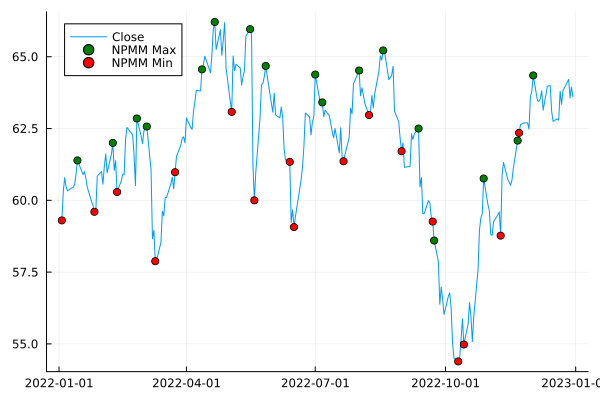

In [99]:
targets = NPMM(test_datas[1], 14)
plot(test_datas[1].Date, test_datas[1].Close, label="Close")
scatter!(test_datas[1].Date[targets .== 1], test_datas[1].Close[targets .== 1], label="NPMM Max", color = :green)
scatter!(test_datas[1].Date[targets .== 0], test_datas[1].Close[targets .== 0], label="NPMM Min", color = :red)

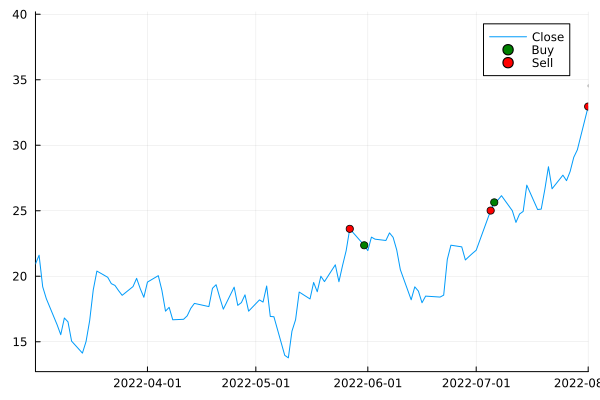

In [100]:
i = 3
buys, sells = zip(eval_dicts[i][:trades]...) .|> collect
plot(test_datas[i].Date, test_datas[i].Close, label="Close")
scatter!(test_datas[i].Date[buys], test_datas[i].Close[buys], label="Buy", color=:green)
scatter!(test_datas[i].Date[sells], test_datas[i].Close[sells], label="Sell", color=:red)
plot!(xlim = (Date(2022, 3, 1), Date(2022, 8, 1)))